<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 37500 - Fixed Income Derivatives</left> 
<br>
<left>Winter 2024</left>

<h2><center> Homework #2- Flat/Forward Volatility, Multiperiod Trees and Caps </center></h2>

<center>Due: Wednesday, Feb 21 at 6PM</center>

<h3><span style="color:#00008B">Name - Nick Lewis</span></h3>
<h3><span style="color:#00008B">Email - nicklewis16@uchicago.edu</span></h3>

# Homework 2

## FINM 37500 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [13]:
import numpy as np
import pandas as pd
import datetime
import warnings
from scipy.stats import norm
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0, '../cmds')
from binomial import *
from ficcvol import *
from ratecurves import *

# 1. Stripping Caps

The file `data/cap_curves_2024-02-16.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.
* the details of the data prep can be found in `build_data/Process Cap Quotes`.

# Funcs used

In [14]:
def flat_to_forward_vol(curves, freq=None, notional=100):
    """
    Converts flat volatilities to forward volatilities using caplet prices and Black's formula.

    Args:
        curves (DataFrame): DataFrame containing the input curves, including 'flat vols', 'swap rates', 'forwards', and 'discounts'.
        freq (int, optional): Frequency of the caplets. If not provided, it is calculated based on the time step of the curves. Defaults to None.
        notional (float, optional): Notional amount. Defaults to 100.

    Returns:
        DataFrame: DataFrame containing the converted forward volatilities.
    """
    
    dt = curves.index[1] - curves.index[0]
    if freq is None:
        freq = int(1/dt)
   
    capcurves = curves[['flat vols']].copy()

    for tstep, t in enumerate(capcurves.index):
    
        if tstep == 0:
            capcurves.loc[t,'caplet prices'] = np.nan
            capcurves.loc[t,'fwd vols'] = np.nan
        else:
            capcurves.loc[t,'cap prices'] = cap_vol_to_price(capcurves.loc[t,'flat vols'], curves.loc[t,'swap rates'], curves.loc[:t,'forwards'], curves.loc[:t,'discounts'], dt=dt)
            capcurves['caplet prices'].loc[t] = capcurves.loc[t,'cap prices'] - capcurves.loc[:tprev,'caplet prices'].sum()
            wrapper = lambda vol: capcurves['caplet prices'].loc[t] - notional * (1/freq) * blacks_formula(tprev, vol, curves.loc[t,'swap rates'], curves.loc[t,'forwards'], curves.loc[t,'discounts'])
            capcurves.loc[t,'fwd vols'] = fsolve(wrapper,capcurves.loc[t,'flat vols'])[0]

        tprev = t
        
    return capcurves

def cap_vol_to_price(flatvol, strike, fwds, discounts, dt=.25, notional=100):
    """
    Calculates the price of a cap option based on flat volatility.

    Parameters:
    - flatvol (float): Flat volatility value.
    - strike (float): Strike price of the cap option.
    - fwds (pd.Series): Series of forward rates.
    - discounts (pd.Series): Series of discount factors.
    - dt (float, optional): Time step size. Defaults to 0.25.
    - notional (float, optional): Notional amount. Defaults to 100.

    Returns:
    - capvalue (float): Price of the cap option.
    """
    T = discounts.index[-1]
    flatvalues = pd.Series(dtype=float, index=discounts.index, name='flat values')
    
    tprev = discounts.index[0]
    for t in discounts.index[1:]:
        flatvalues.loc[t] = notional * dt * blacks_formula(tprev, flatvol, strike, fwds.loc[t], discounts.loc[t])
        tprev = t
        
    capvalue = flatvalues.sum()        
    return capvalue

def blacks_formula(T, vol, strike, fwd, discount=1, isCall=True):
    """
    Calculates the value of a European option using Black's formula.

    Parameters:
    - T (float): Time to expiration in years.
    - vol (float): Volatility of the underlying asset.
    - strike (float): Strike price of the option.
    - fwd (float): Forward price of the underlying asset.
    - discount (float, optional): Discount factor. Default is 1.
    - isCall (bool, optional): True if the option is a call option, False if it's a put option. Default is True.

    Returns:
    - val (float): Value of the option.

    """
    sigT = vol * np.sqrt(T)
    d1 = (1/sigT) * np.log(fwd/strike) + .5*sigT
    d2 = d1 - sigT
    
    if isCall:
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    
    return val


def estimate_theta(sigmas, quotes_zeros, dt=None, T=None):
    """
    Estimates the theta values for a given set of sigmas and zero quotes.

    Parameters:
    - sigmas (float or pd.Series): The volatility values for each time step.
    - quotes_zeros (pd.Series): The zero quotes for each time step.
    - dt (float, optional): The time step size. If not provided, it is calculated from the index of quotes_zeros.
    - T (float, optional): The maturity time. If not provided, it is calculated from the index of quotes_zeros.

    Returns:
    - theta (pd.Series): The estimated theta values for each time step.
    - ratetree (pd.DataFrame): The rate tree constructed during the estimation process.
    """
    if dt is None:
        dt = quotes_zeros.index[1] - quotes_zeros.index[0]

    if T is None:
        T = quotes_zeros.index[-2]

    if quotes_zeros.mean() < 1:
        scale = 1
    else:
        scale = 100
        
    ratetree = construct_rate_tree(dt, T)
    theta = pd.Series(dtype=float, index=ratetree.columns, name='theta')
    dt = ratetree.columns[1] - ratetree.columns[0]
    
    if type(sigmas) is float:
        sigmas = pd.Series(sigmas, index=theta.index)

    for tsteps, t in enumerate(quotes_zeros.index):
        if tsteps == 0:
            ratetree.loc[0, 0] = -np.log(quotes_zeros.iloc[tsteps] / scale) / dt
        else:
            subtree = ratetree.iloc[:tsteps+1, :tsteps+1]
            wrapper = lambda theta: incremental_BDT_pricing(subtree, theta, sigmas.iloc[tsteps]).loc[0, 0] - quotes_zeros.iloc[tsteps] * 100 / scale
            
            theta.iloc[tsteps] = fsolve(wrapper, .5)[0]
            ratetree.iloc[:tsteps+1, tsteps] = incrementBDTtree(subtree, theta.iloc[tsteps], sigmas.iloc[tsteps]).iloc[:, tsteps]
            
            #print(f'Completed: {tsteps/len(quotes_zeros.index):.1%}')
            
    return theta, ratetree

def construct_rate_tree(dt,T):
    """
    Constructs a rate tree based on the given time step and time horizon.

    Parameters:
    dt (float): The time step.
    T (float): The time horizon.

    Returns:
    pd.DataFrame: The rate tree.
    """
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree

## Context

Recall that 
* a cap is made of caplets with $.5\le \tau \le T$
* the flat volatility at $T$ is input for every caplet corresponding to the cap of $T$.
* use Black's formula for this calculation.
* in Black's formula, use $T-0.25$ as the rate for the caplet is determined one period before it is paid.

As for the cap parameters,
* the cap's strike is the swap rate with the same tenor. So the $T=2$ cap is struck at the swap rate of $\tau=2$.
* the notional of the cap is $100.
* the payoff of each caplet is

$$\frac{100}{n}\max(r-K,0)$$

where $n$ is the frequency; here $n=4$.

Thus, the corresponding value in Black's fomula for a caplet is
$$P^{\text{cap}}_{T} = \frac{100}{n} \sum_{\tau=.5}^T B_{\text{call}}(\overline{\sigma}_T, \tau-.25, K=s_T, f_{\tau}, Z_{\tau})$$
Note here that for every caplet in cap $T$, we plug in the same 
* flat vol with tenor $T$.
* strike which is the swap rate of maturity $T$.

The notation above is using subscripts for tenor / maturity rather than time period. That is, $Z_{\tau}$ denotes $Z(t, t+\tau)$ which is today's discount factor for maturity $\tau$. Similarly for the swap rate of tenor $T$, denoted above $s_T$ and forward rate $f(t,t+\tau-.25, t+\tau)$ denoted simply $f_{\tau}$.

### Black's Formula
Recall Black's formula:

$$\begin{align}
B_{\text{call}}(\sigma, T, K, f, Z) = &\; Z\left[f\mathcal{N}\left(d_1\right) - K\mathcal{N}(d_2)\right] \\
d_1 =& \frac{\ln\left(\frac{f}{K}\right) + \frac{\sigma^2}{2}T}{\sigma\sqrt{T}} \\
d_2 =& d_1 -\sigma\sqrt{T}
\end{align}
$$

## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

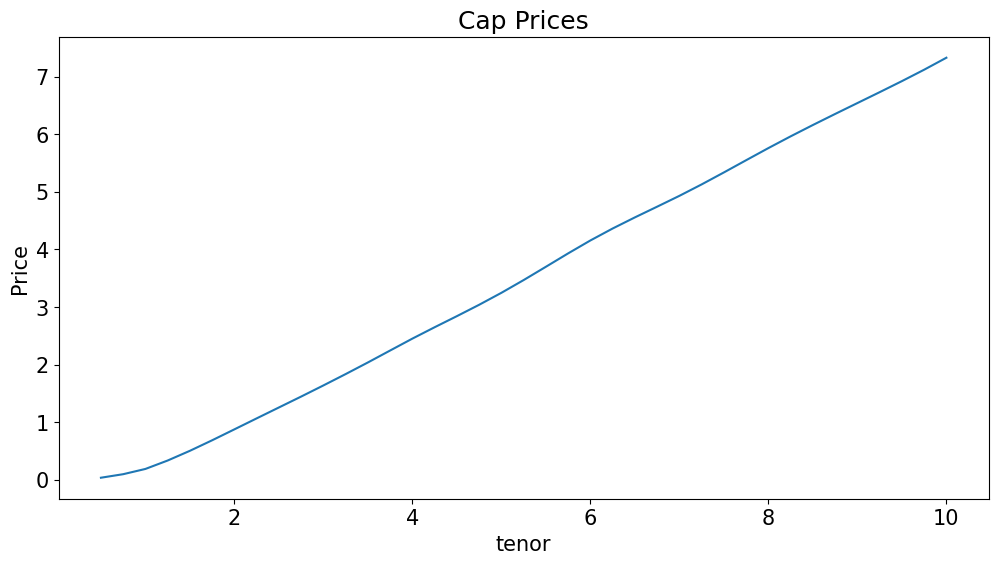

In [21]:
DATE = '2024-02-16'
FILEPATH = f'../data/cap_curves_{DATE}.xlsx'
curves = pd.read_excel(FILEPATH, sheet_name= f'rate curves {DATE}', index_col='tenor')
capcurves = flat_to_forward_vol(curves)
capcurves['cap prices'].plot(title = 'Cap Prices', ylabel = 'Price')
plt.show()

## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

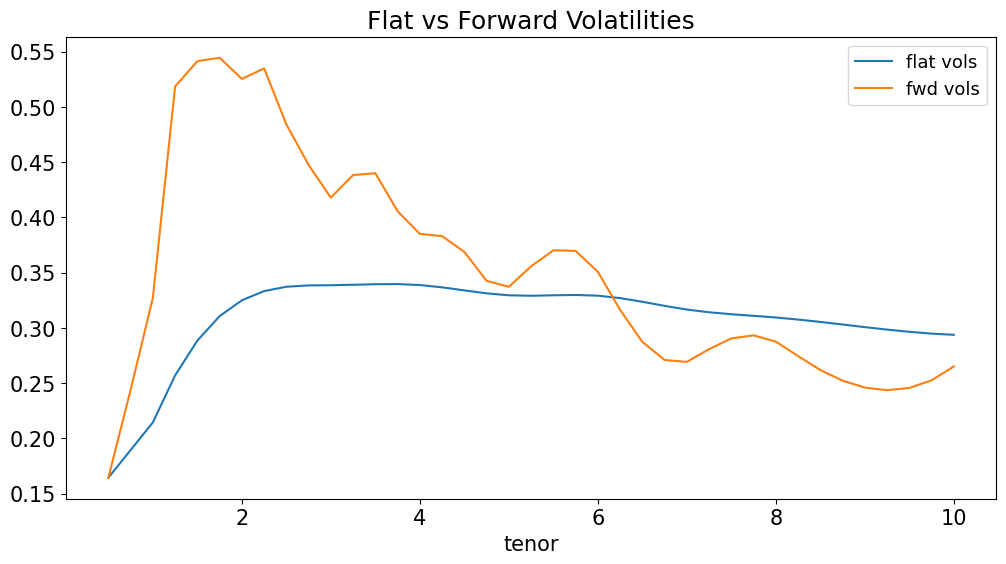

In [19]:
capcurves[['flat vols', 'fwd vols']].plot(title = 'Flat vs Forward Volatilities')
plt.show()

In [23]:
capcurves # calculates flat vols, caplet prices, forward vols, and cap prices

,flat vols,caplet prices,fwd vols,cap prices
tenor,,,,
0.25,NaN,NaN,NaN,NaN
0.50,0.164498,0.034285,0.164498,0.034285
0.75,0.189530,0.061272,0.244029,0.095557
1.00,0.214562,0.091266,0.327210,0.186823
1.25,0.257098,0.146312,0.518534,0.333136
1.50,0.288577,0.168763,0.541362,0.501898
1.75,0.310668,0.182799,0.544506,0.684697
2.00,0.325038,0.189741,0.525341,0.874438
2.25,0.333356,0.190485,0.534827,1.064923


## 1.3 Calibrate a BDT model 

Use data from the file `data/cap_curves_2024-02-16.xlsx` to calibrate the BDT model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
* You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.    

Given these volatility parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

**Display**
* the series of $\theta$ parameters.
* the tree of rates from $0\le t \le 10$.

In [29]:
quotes = curves['discounts'] * 100
sigmas = capcurves['fwd vols']
sigmas.iloc[0] = sigmas.iloc[1] # use first estimated forward vol for both t = .25 and t = .50
theta, ratetree = estimate_theta(sigmas, quotes)
print('Theta parameters: ')
display(format_bintree(theta.to_frame().T, style = '{:.2%}'))
print('Rate tree: ')
display(format_bintree(ratetree, style = '{:.2%}'))

Theta parameters: 


time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
theta,,-11.18%,-29.62%,-44.17%,-96.03%,-64.37%,-54.44%,-38.46%,-49.59%,-9.02%,0.17%,11.93%,-12.15%,-0.83%,27.02%,21.08%,5.65%,19.09%,40.00%,35.05%,20.19%,15.02%,15.61%,20.20%,27.72%,32.20%,33.55%,31.84%,27.61%,24.58%,23.21%,23.58%,25.41%,26.92%,27.77%,27.95%,27.37%,25.94%,23.58%,20.15%


Rate tree: 


time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.29%,5.58%,5.86%,6.18%,6.30%,7.03%,8.05%,9.51%,10.98%,13.67%,17.11%,21.72%,26.23%,32.62%,42.75%,54.63%,67.10%,84.64%,111.02%,143.44%,180.24%,225.20%,281.71%,353.12%,443.32%,554.75%,690.82%,855.89%,1055.30%,1297.62%,1592.35%,1950.30%,2384.03%,2906.86%,3534.83%,4286.97%,5185.45%,6256.26%,7529.75%,9041.48%
1,,4.74%,4.97%,5.24%,5.34%,5.96%,6.83%,8.07%,9.31%,11.60%,14.51%,18.43%,22.25%,27.67%,36.26%,46.34%,56.92%,71.80%,94.18%,121.69%,152.90%,191.04%,238.98%,299.55%,376.08%,470.60%,586.04%,726.07%,895.23%,1100.80%,1350.82%,1654.48%,2022.42%,2465.95%,2998.67%,3636.72%,4398.92%,5307.30%,6387.64%,7670.06%
2,,,3.89%,4.10%,4.18%,4.67%,5.35%,6.32%,7.30%,9.09%,11.37%,14.44%,17.44%,21.68%,28.41%,36.31%,44.60%,56.25%,73.79%,95.34%,119.80%,149.68%,187.23%,234.69%,294.64%,368.70%,459.14%,568.85%,701.38%,862.44%,1058.32%,1296.23%,1584.50%,1931.98%,2349.35%,2849.24%,3446.40%,4158.09%,5004.49%,6009.23%
3,,,,2.96%,3.02%,3.37%,3.86%,4.56%,5.26%,6.55%,8.20%,10.41%,12.57%,15.63%,20.48%,26.18%,32.15%,40.55%,53.19%,68.73%,86.36%,107.91%,134.98%,169.20%,212.42%,265.81%,331.01%,410.10%,505.65%,621.76%,762.98%,934.49%,1142.31%,1392.83%,1693.72%,2054.11%,2484.62%,2997.70%,3607.90%,4332.25%
4,,,,,1.80%,2.00%,2.30%,2.71%,3.13%,3.90%,4.88%,6.20%,7.48%,9.31%,12.19%,15.58%,19.14%,24.15%,31.67%,40.92%,51.42%,64.25%,80.37%,100.74%,126.47%,158.26%,197.08%,244.17%,301.06%,370.19%,454.27%,556.39%,680.13%,829.28%,1008.43%,1223.00%,1479.33%,1784.81%,2148.12%,2579.39%
5,,,,,,1.17%,1.34%,1.58%,1.82%,2.27%,2.84%,3.61%,4.36%,5.42%,7.10%,9.07%,11.14%,14.05%,18.43%,23.81%,29.92%,37.39%,46.77%,58.62%,73.60%,92.10%,114.69%,142.10%,175.20%,215.43%,264.37%,323.79%,395.80%,482.60%,586.86%,711.73%,860.90%,1038.68%,1250.11%,1501.09%
6,,,,,,,0.78%,0.92%,1.06%,1.32%,1.65%,2.09%,2.53%,3.14%,4.12%,5.26%,6.46%,8.15%,10.69%,13.82%,17.36%,21.69%,27.13%,34.01%,42.70%,53.43%,66.54%,82.43%,101.64%,124.98%,153.37%,187.84%,229.62%,279.97%,340.45%,412.90%,499.43%,602.57%,725.22%,870.82%
7,,,,,,,,0.54%,0.63%,0.78%,0.97%,1.24%,1.49%,1.86%,2.43%,3.11%,3.82%,4.82%,6.32%,8.17%,10.27%,12.83%,16.05%,20.11%,25.25%,31.60%,39.35%,48.75%,60.11%,73.91%,90.69%,111.08%,135.78%,165.56%,201.33%,244.17%,295.34%,356.33%,428.86%,514.96%
8,,,,,,,,,0.37%,0.46%,0.57%,0.72%,0.88%,1.09%,1.43%,1.82%,2.24%,2.82%,3.70%,4.79%,6.01%,7.51%,9.40%,11.78%,14.79%,18.51%,23.05%,28.56%,35.21%,43.29%,53.13%,65.07%,79.54%,96.98%,117.93%,143.03%,173.00%,208.73%,251.22%,301.65%


***

# 2. Pricing a Callable Bond with BDT

## Freddie Mac

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond with Bloomberg ID `COZD1131782`, CUSIP `3134H1TN3`.
* Issued 2024-02-16
* Matures 2034-02-21
* Semiannual coupons
* Coupon rate 6.00%

Note that these bonds are not a niche market. Just this particular bond was issued with \$15 billion face value.

## 2.1 Price the Freddie Mac Bond


Assume today is `2024-02-16`.
* The market price on this day is `$99.953`.
* Approximate the TTM (time-to-maturity) to be exactly 10 years.

Price this bond using the model calibrated from  data.
* Price it with the BDT model calibrated in the previous problem.
* Note that the coupons are paid semiannually whereas the tree steps are quarterly.

Report the tree of bond prices, emphasizing the current modeled price.

How does our modeled price compare to the market price?

In [43]:
FACE = 100
T = 10
compound = 4
cpn = .06
cpn_freq = 2

QUOTE_CALLABLE_CLEAN = 99.953
STRIKE = 100
CLEANCALL = True

dt = 1/compound
tsteps = int(T/dt)

wrapper_bond = lambda r: payoff_bond(r, dt, facevalue= FACE * (1 + cpn/ cpn_freq))
payoff_call = lambda p: np.maximum(p - STRIKE, 0)

In [44]:
cftree = construct_bond_cftree(T, compound, cpn)
bondtree = bintree_pricing(payoff = wrapper_bond, ratetree = ratetree.iloc[:tsteps, :tsteps], cftree=cftree)
format_bintree(bondtree, style = '{:.2f}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,111.87,103.58,97.71,88.36,81.46,71.30,63.99,53.79,46.77,37.32,31.51,23.63,19.53,13.49,11.29,7.13,6.39,3.51,3.71,1.71,2.29,0.79,1.40,0.29,0.78,0.08,0.36,0.01,0.12,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,124.53,117.30,112.50,104.11,98.05,88.51,81.51,71.27,63.80,53.47,46.39,36.90,30.94,22.89,18.74,12.75,10.46,6.29,5.57,2.89,3.09,1.26,1.78,0.49,1.00,0.15,0.50,0.03,0.19,0.00,0.05,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2,,,128.72,125.04,117.84,112.97,104.55,98.55,89.08,82.10,71.88,64.50,54.25,47.09,37.42,31.39,23.33,18.95,12.75,10.34,6.21,5.39,2.71,2.79,1.05,1.49,0.35,0.78,0.09,0.35,0.01,0.12,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,134.90,128.83,125.19,118.05,113.36,105.16,99.34,90.08,83.40,73.49,66.25,56.01,48.96,39.41,33.21,24.87,20.32,14.04,11.37,6.98,5.85,3.00,2.89,1.12,1.44,0.36,0.70,0.09,0.30,0.01,0.09,0.00,0.02,0.00,0.00,0.00,0.00
4,,,,,136.98,134.41,128.44,125.03,118.17,113.76,105.88,100.50,91.71,85.42,75.78,68.95,59.12,52.22,42.63,36.49,28.21,23.48,16.81,13.71,8.85,7.32,4.09,3.71,1.66,1.85,0.58,0.91,0.16,0.41,0.03,0.15,0.00,0.04,0.01,0.16
5,,,,,,140.79,135.73,133.34,127.60,124.43,117.86,113.85,106.42,101.47,93.07,87.30,78.25,71.83,62.30,55.80,46.63,40.68,32.33,27.40,20.42,16.95,11.65,9.70,5.98,5.21,2.74,2.69,1.12,1.37,0.41,0.67,0.17,0.36,0.31,2.42
6,,,,,,,140.67,139.03,134.13,131.93,126.42,123.56,117.34,113.70,106.64,102.18,94.36,89.09,80.49,74.67,65.81,59.83,51.00,45.28,37.03,32.13,25.03,21.35,15.69,13.33,9.11,7.93,4.99,4.65,2.72,2.88,1.81,2.49,3.27,11.68
7,,,,,,,,142.86,138.56,137.05,132.31,130.32,125.06,122.48,116.56,113.30,106.71,102.71,95.35,90.67,82.78,77.62,69.33,63.89,55.56,50.29,42.41,37.77,30.79,27.12,21.33,18.82,14.38,13.06,10.00,9.84,8.39,10.13,13.16,28.43
8,,,,,,,,,141.55,140.51,136.32,134.95,130.38,128.58,123.54,121.23,115.66,112.76,106.56,103.06,96.31,92.25,84.97,80.44,72.81,68.07,60.43,55.82,48.54,44.44,37.91,34.69,29.31,27.32,23.51,23.24,21.85,24.97,30.20,48.45


## 2.2 Callable Bond

One important difference between Treasury debt and this bond is that this bond is **callable**
* Note that the holder of the bond is short this call option; (the issuer has the optionality.) 

#### Style
* (approximately) American style
* called only on quarterly dates, not any date
* since our tree is quarterly, this means callable on any date on our tree.

#### Strike
* Strike is 100.
* The strike is based on the **clean** price of the bond, meaning the price which does not account for accrued interest.
    * In pricing the bond in the previous problem, you should have considered the accrued coupons, or dirty prices.
    * But in analyzing the option, you must consider its moneyness and payoff based on the clean price.

### Pricing
Use the BDT model to price this implicit American call option and the resulting callable bond.
* Note that the price of the callable bond is your answer to the previous question minus this American option.
* How close is the modeled price to the market quoted price now that you are accounting for the short embedded option? 

Does the price of the callable bond ever get above \$100?

In [45]:
accint = construct_accint(bondtree.columns.values, compound, cpn)
cleantree = np.maximum(bondtree.subtract(accint, axis=1), 0)
format_bintree(cleantree, style = '{:.2f}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,110.37,103.58,96.21,88.36,79.96,71.30,62.49,53.79,45.27,37.32,30.01,23.63,18.03,13.49,9.79,7.13,4.89,3.51,2.21,1.71,0.79,0.79,0.00,0.29,0.00,0.08,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,123.03,117.30,111.00,104.11,96.55,88.51,80.01,71.27,62.30,53.47,44.89,36.90,29.44,22.89,17.24,12.75,8.96,6.29,4.07,2.89,1.59,1.26,0.28,0.49,0.00,0.15,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,128.72,123.54,117.84,111.47,104.55,97.05,89.08,80.60,71.88,63.00,54.25,45.59,37.42,29.89,23.33,17.45,12.75,8.84,6.21,3.89,2.71,1.29,1.05,0.00,0.35,0.00,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,133.40,128.83,123.69,118.05,111.86,105.16,97.84,90.08,81.90,73.49,64.75,56.01,47.46,39.41,31.71,24.87,18.82,14.04,9.87,6.98,4.35,3.00,1.39,1.12,0.00,0.36,0.00,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,136.98,132.91,128.44,123.53,118.17,112.26,105.88,99.00,91.71,83.92,75.78,67.45,59.12,50.72,42.63,34.99,28.21,21.98,16.81,12.21,8.85,5.82,4.09,2.21,1.66,0.35,0.58,0.00,0.16,0.00,0.03,0.00,0.00,0.00,0.01,0.00
5,,,,,,139.29,135.73,131.84,127.60,122.93,117.86,112.35,106.42,99.97,93.07,85.80,78.25,70.33,62.30,54.30,46.63,39.18,32.33,25.90,20.42,15.45,11.65,8.20,5.98,3.71,2.74,1.19,1.12,0.00,0.41,0.00,0.17,0.00,0.31,0.92
6,,,,,,,140.67,137.53,134.13,130.43,126.42,122.06,117.34,112.20,106.64,100.68,94.36,87.59,80.49,73.17,65.81,58.33,51.00,43.78,37.03,30.63,25.03,19.85,15.69,11.83,9.11,6.43,4.99,3.15,2.72,1.38,1.81,0.99,3.27,10.18
7,,,,,,,,141.36,138.56,135.55,132.31,128.82,125.06,120.98,116.56,111.80,106.71,101.21,95.35,89.17,82.78,76.12,69.33,62.39,55.56,48.79,42.41,36.27,30.79,25.62,21.33,17.32,14.38,11.56,10.00,8.34,8.39,8.63,13.16,26.93
8,,,,,,,,,141.55,139.01,136.32,133.45,130.38,127.08,123.54,119.73,115.66,111.26,106.56,101.56,96.31,90.75,84.97,78.94,72.81,66.57,60.43,54.32,48.54,42.94,37.91,33.19,29.31,25.82,23.51,21.74,21.85,23.47,30.20,46.95


## 2.3 Exercising the Option

Show a heatmap of the nodes in which the American bond is exercised.

Is it exercised every time it is in-the-money?

In [46]:
if CLEANCALL:
    undertree = cleantree
else:
    undertree = bondtree
    
calltree = bintree_pricing(payoff = payoff_call, ratetree = ratetree.iloc[:tsteps, :tsteps], undertree=undertree, style = 'american')
format_bintree(calltree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,19.07,15.06,11.52,8.51,6.06,4.15,2.73,1.72,1.03,0.59,0.31,0.16,0.07,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,23.59,19.02,14.88,11.22,8.16,5.72,3.85,2.49,1.53,0.90,0.50,0.26,0.12,0.05,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,28.72,23.64,18.94,14.58,10.84,7.79,5.37,3.56,2.26,1.37,0.78,0.42,0.21,0.10,0.04,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,33.40,28.83,23.69,18.67,14.18,10.45,7.39,5.02,3.28,2.05,1.21,0.68,0.36,0.17,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,36.98,32.91,28.44,23.53,18.22,13.80,10.00,6.97,4.68,3.01,1.85,1.07,0.59,0.30,0.14,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,,,,,,39.29,35.73,31.84,27.60,22.93,17.86,13.29,9.47,6.52,4.32,2.73,1.64,0.93,0.49,0.24,0.11,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,,,,,,,40.67,37.53,34.13,30.43,26.42,22.06,17.34,12.63,8.90,6.07,3.95,2.45,1.44,0.79,0.41,0.19,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,,,,,,,,41.36,38.56,35.55,32.31,28.82,25.06,20.98,16.56,11.91,8.34,5.58,3.56,2.16,1.24,0.66,0.32,0.14,0.05,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,,,,,,,,,41.55,39.01,36.32,33.45,30.38,27.08,23.54,19.73,15.66,11.26,7.74,5.08,3.17,1.88,1.04,0.53,0.24,0.10,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [55]:
num_accrued = int((T * compound)% cpn_freq)
quote_callable_dirty = QUOTE_CALLABLE_CLEAN + num_accrued * (cpn/ compound) * FACE
callablebondtree = bondtree - calltree
model_price_dirty = callablebondtree.iloc[0,0]
model_price_clean = model_price_dirty - accint.iloc[0]

prices = pd.DataFrame({'clean': [QUOTE_CALLABLE_CLEAN, model_price_clean], 'dirty': [quote_callable_dirty, model_price_dirty]}, index = ['market', 'model'])
prices.style.format('{:.4f}')

,clean,dirty
market,99.9530,99.9530
model,97.5745,97.5745


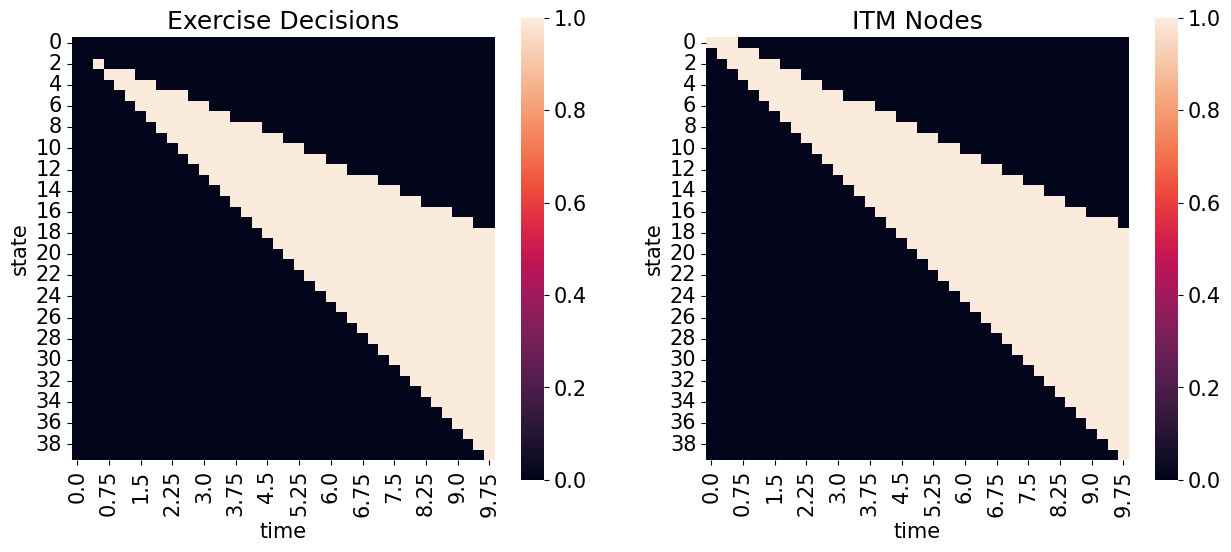

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first heatmap
sns.heatmap(exercise_decisions(payoff_call, undertree, calltree), square=True, ax=axs[0]).set_title('Exercise Decisions')

# Plot the second heatmap
sns.heatmap(undertree > STRIKE, square=True, ax=axs[1]).set_title('ITM Nodes')

plt.show()

***

# 3. Option Adjusted Spread

*This section is optional. No need to submit it, but we will likely discuss it in class.*

## 3.1 Calculate the OAS

The **option adjusted spread** is the spread one would need to add to the spot curve, (the discounts), to get the modeled price to match the market price of the derivative. That is, how many bps would you need to add or subtract to all the spot rates in order to perfectly price this callable bond? 

* Ignore the effect of the parallel shift in rates on the forward vols. (No need to recalculate section 1.) 

* Use the parallel shifts to recalibrate the $\theta$ parameters in the BDT tree. 

Report the OAS needed to add (or subtract) in a parallel shift in spot to correctly model the callable bond.

#### Note:
This **OAS** is a common way to quote whether a derivative seems to be undervalued (positive OAS) or overvalued (negative OAS.) Of course, the OAS is dependent on our modeling choices, so it could also indicate the model is bad.

## 3.2 Convexity

Continue with parallel shifts of the (present, market quoted) yield curve. 
* Plot the relationship between the value of the callable bond as the spot curve shifts higher and lower.
* Do you see convexity in this relationship?

***